In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

2025-07-03 14:18:18.743536: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 14:18:23.345194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 14:18:25.332841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751552308.845185    1572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751552309.689553    1572 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751552316.724140    1572 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
df = pd.read_csv("airsim_rec.txt", sep=r'\s+')
positions = df[['POS_X', 'POS_Y', 'POS_Z']].values

print(len(positions))

406


## 1. Normalize the data

In [3]:
# Split positions BEFORE scaling
positions_train, positions_test = train_test_split(positions, test_size=0.2, shuffle=False)

# Fit scaler on training data only (no leakage!)
scaler = StandardScaler()
positions_train_scaled = scaler.fit_transform(positions_train)
positions_test_scaled = scaler.transform(positions_test)

## 2. Create Sequences

In [4]:
# Create sequences for train and test
def create_sequences(data, window_size=10):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

X_train = create_sequences(positions_train_scaled, window_size=10)
X_test = create_sequences(positions_test_scaled, window_size=10)

## 3. LSTM Autoencoder

In [5]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mse')

2025-07-03 14:18:47.960313: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 4. Train the model

In [6]:
model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.6903 - val_loss: 1.0380
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2386 - val_loss: 0.6527
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1418 - val_loss: 0.4697
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1032 - val_loss: 0.4271
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0882 - val_loss: 0.4529
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0734 - val_loss: 0.4160
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0605 - val_loss: 0.3767
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0507 - val_loss: 0.3634
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0424 - val_loss: 0.3481
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0369 - val_loss: 0.3274
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0362 - val_loss: 0.3201
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0307 - val_loss: 0.2983
Epoch 13/50


## 5. Reconstruction Error to Detect Anomalies

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


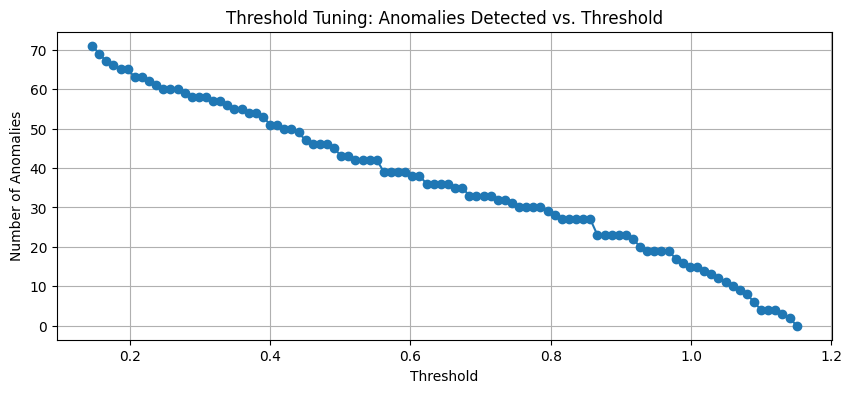

In [7]:
X_pred = model.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_pred), axis=(1, 2))

thresholds = np.linspace(
    np.min(reconstruction_error),
    np.max(reconstruction_error),
    100
)

anomaly_counts = []

for t in thresholds:
    count = np.sum(reconstruction_error > t)
    anomaly_counts.append(count)

plt.figure(figsize=(10, 4))
plt.plot(thresholds, anomaly_counts, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Number of Anomalies")
plt.title("Threshold Tuning: Anomalies Detected vs. Threshold")
plt.grid(True)
plt.show()

In [8]:
# Use 95th percentile of reconstruction error as anomaly threshold
# This flags the top ~5% most abnormal points as anomalies
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

print(threshold)

1.1061390415360988


## Print Anomalies & Plot Results

In [9]:
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        #print(f"Anomaly at sequence index {i}, position: {positions[i+10]}")
        current_index = i + 10  # shift due to sequence length

        print(f"\nAnomaly at sequence index {i}, position: {positions[current_index]}")

        # Print previous position (if within bounds)
        if current_index - 1 >= 0:
            print(f"   ↳ Previous position: {positions[current_index - 1]}")

        # Print next position (if within bounds)
        if current_index + 1 < len(positions):
            print(f"   ↳ Next position:     {positions[current_index + 1]}")


Anomaly at sequence index 55, position: [ 30.8579  -10.8507   -7.20184]
   ↳ Previous position: [ 30.8521  -10.7207   -7.09897]
   ↳ Next position:     [ 30.8493  -11.0354   -7.28073]

Anomaly at sequence index 56, position: [ 30.8493  -11.0354   -7.28073]
   ↳ Previous position: [ 30.8579  -10.8507   -7.20184]
   ↳ Next position:     [ 30.8354  -11.23     -7.25866]

Anomaly at sequence index 57, position: [ 30.8354  -11.23     -7.25866]
   ↳ Previous position: [ 30.8493  -11.0354   -7.28073]
   ↳ Next position:     [ 30.8258  -11.3184   -7.31377]

Anomaly at sequence index 58, position: [ 30.8258  -11.3184   -7.31377]
   ↳ Previous position: [ 30.8354  -11.23     -7.25866]
   ↳ Next position:     [ 30.8008  -11.3286   -7.58562]


Data stats: I have around 406 total data points. With a 95th percentile threshold on reconstruction error, around 4 points were flagged as anomalies (about 1% anomaly rate). This threshold was selected heuristically from the error distribution.

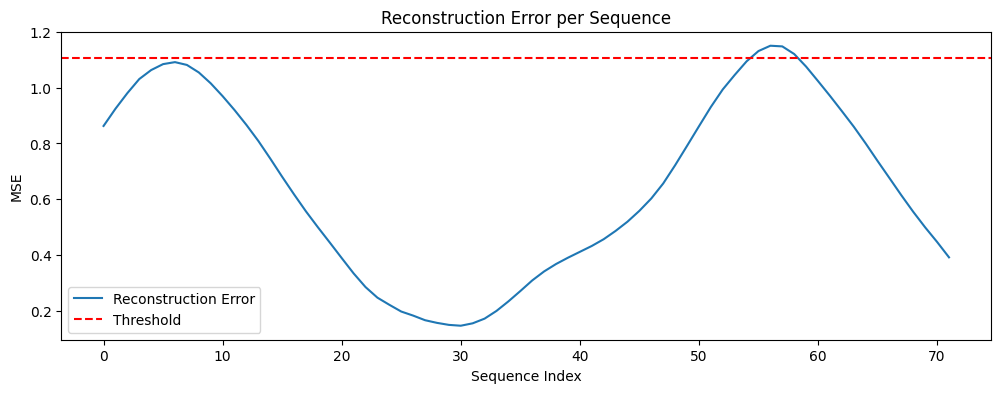

In [10]:
# This graph shows reconstruction error over time, with a red line marking the anomaly threshold.
plt.figure(figsize=(12, 4))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.title("Reconstruction Error per Sequence")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.show()

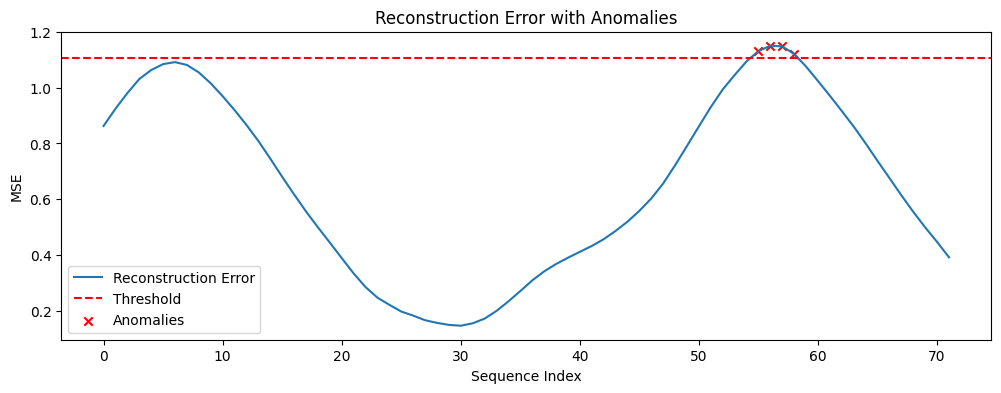

In [11]:
# This graph highlights where reconstruction error exceeds the threshold, marking detected anomalies with red Xs.
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(12, 4))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Overlay anomalies
plt.scatter(anomaly_indices, reconstruction_error[anomaly_indices], color='red', label='Anomalies', marker='x')

plt.title("Reconstruction Error with Anomalies")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.show()

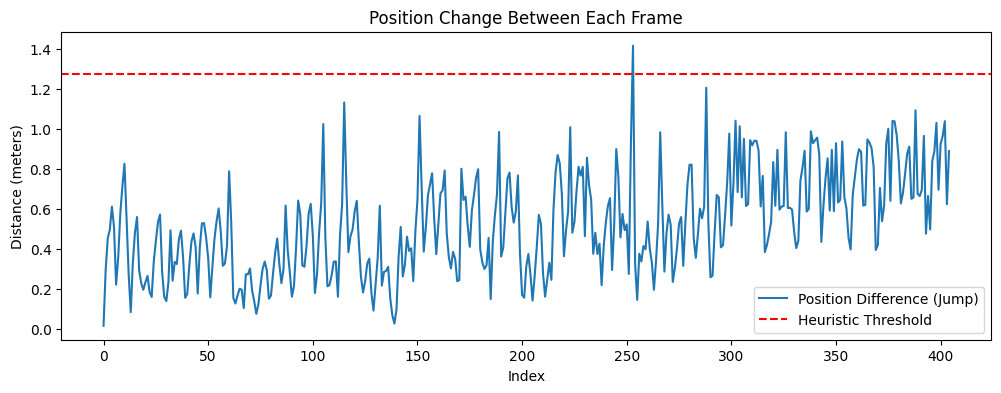

In [12]:
# Compute the Euclidean distance between consecutive points.
# This graph shows the magnitude of positional changes between each frame to 
# help identify suspiciously large jumps that may indicate spoofing or tracking errors.
position_diff = np.linalg.norm(np.diff(positions, axis=0), axis=1)

plt.figure(figsize=(12, 4))
plt.plot(position_diff, label="Position Difference (Jump)")
plt.title("Position Change Between Each Frame")
plt.xlabel("Index")
plt.ylabel("Distance (meters)")
plt.axhline(y=np.mean(position_diff) + 3*np.std(position_diff), color='r', linestyle='--', label='Heuristic Threshold')
plt.legend()
plt.show()


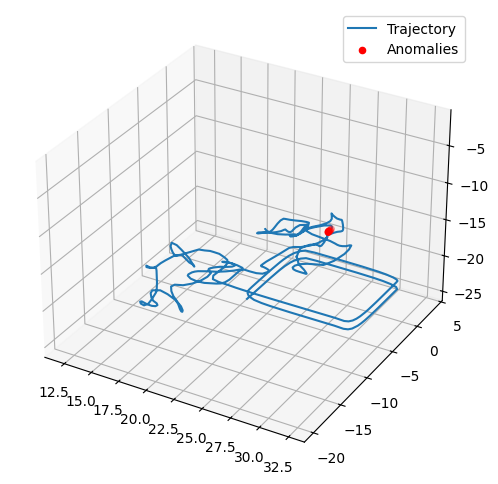

In [13]:
# 3D plot of the drone's flight path (blue) with detected anomalies marked in red.
# Anomalies indicate unusual movements that differ from the learned normal pattern.

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Trajectory')
ax.scatter(positions[anomaly_indices + 10][:, 0],  # +10 for offset
           positions[anomaly_indices + 10][:, 1],
           positions[anomaly_indices + 10][:, 2],
           color='red', label='Anomalies')
ax.legend()
plt.show()